## Stock Prediction Project

Scrape Data via API. We will use yfinance

In [1]:
!pip install yfinance

In [6]:
import yfinance as yf
import datetime 
from datetime import date
import matplotlib.pyplot as pyplot
import urllib.request
import json

from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np

In our case, we will use Walt Disney (NYSE: DIS) as our sample dataset

In [3]:
stock = input("Please select your stock/share/forex: ")
today = date.today()

Please select your stock/share/forex: DIS


In [7]:
dataframe = yf.download(stock, "2010-01-01", today, auto_adjust=True)
dataframe = dataframe[["Close"]] #only require close for prediction
dataframe = dataframe.dropna()
print(len(dataframe))
dataframe.head()

[*********************100%***********************]  1 of 1 completed
3242


,Close
Date,
2010-01-04,27.933920
2010-01-05,27.864241
2010-01-06,27.716166
2010-01-07,27.724874
2010-01-08,27.768425


In [8]:
def get_yahoo_shortname(symbol):
    response = urllib.request.urlopen(f'https://query2.finance.yahoo.com/v1/finance/search?q={symbol}')
    content = response.read()
    data = json.loads(content.decode('utf8'))['quotes'][0]['shortname']
    return data

In [9]:
name = get_yahoo_shortname(stock)

Text(0.5, 1.0, 'Walt Disney Company (The) (DIS) - 2010 - 2022')

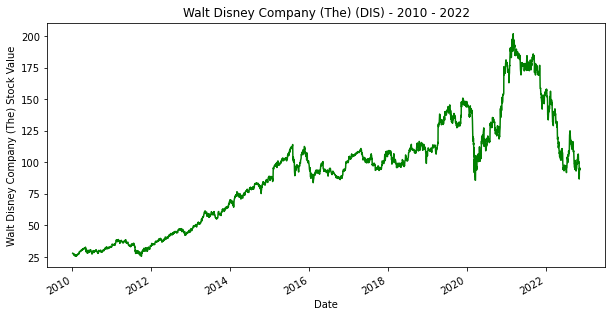

In [10]:
# visualize the dataset
dataframe.Close.plot(figsize = (10, 5), color = "g")
pyplot.ylabel(name+" Stock Value")
pyplot.title(name+" ("+stock+") - 2010 - "+today.strftime("%Y"))

Define variables

In [11]:
dataframe["five_days_moving_avg"] = dataframe["Close"].rolling(window=5).mean()
dataframe["twenty_days_moving_avg"] = dataframe["Close"].rolling(window=20).mean()

dataframe = dataframe.dropna()

X = dataframe[["five_days_moving_avg", "twenty_days_moving_avg"]]

dataframe["value_next_day"] = dataframe["Close"].shift(-1)
dataframe = dataframe.dropna()

y = dataframe["value_next_day"]

Split Dataset into Train and Test

In [12]:
split_index = 0.8 # Split data into 80:20

split_index = split_index * len(dataframe)

split_index = int(split_index)

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

Prepare Linear Regression Model

In [13]:
model = LinearRegression()
model = model.fit(X_train, y_train)
five_day_moving_avg = model.coef_[0]
twenty_day_moving_avg = model.coef_[1]

print(five_day_moving_avg)
print(twenty_day_moving_avg)

1.1961864421733819
-0.19847726363483353


In [14]:
constant = model.intercept_
print(constant)

0.22810346831205663


Make prediction on Stock Prices

Text(0, 0.5, 'Walt Disney Company (The) Stock Value')

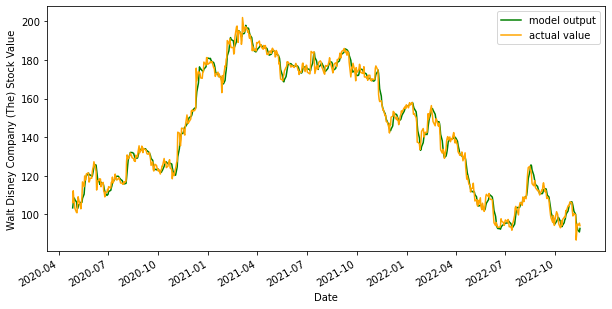

In [15]:
test_output = model.predict(X_test)

y_test = y[(split_index - 1):]

test_output = pd.DataFrame(test_output, index= y_test.index, columns = ["value"])

test_output.plot(figsize = (10, 5), color = "g")
y_test.plot(color = "orange")

pyplot.legend(["model output", "actual value"])
pyplot.ylabel(name+" Stock Value")

Calculate Model Accuracy

In [16]:
score = model.score(X[split_index:], y[(split_index -1):])

score = score*100

print(score)

99.07337107232878


This model are able to achieve 99% of accuracy which show a good pattern

Text(0, 0.5, 'Cumulative Returns')

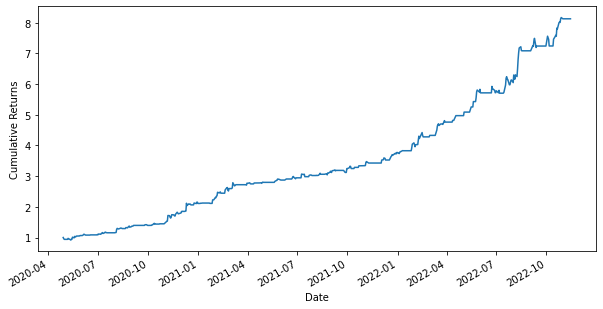

In [17]:
stocks = pd.DataFrame()
stocks["value"] = dataframe[split_index:]["Close"]

stocks["predicted_tomorrow_value"] = test_output

stocks["actual_tomorrow_value"] = y_test

stocks["returns"] = stocks["value"].pct_change().shift(-1) # pct = percentage

stocks["strategy"] = np.where(stocks.predicted_tomorrow_value.shift(1) < stocks.predicted_tomorrow_value, 1, 0)

stocks["strategy_returns"] = stocks.strategy * stocks["returns"]

cumulative_product = (stocks["strategy_returns"]+1).cumprod()

cumulative_product.plot(figsize = (10, 5))
pyplot.ylabel("Cumulative Returns")

In [18]:
print(stocks.head())

                 value  predicted_tomorrow_value  actual_tomorrow_value  \
Date                                                                      
2020-04-28  106.209999                105.950315             112.250000   
2020-04-29  112.250000                107.529569             108.150002   
2020-04-30  108.150002                108.476031             105.500000   
2020-05-01  105.500000                107.694736             103.180000   
2020-05-04  103.180000                106.447977             101.059998   

             returns  strategy  strategy_returns  
Date                                              
2020-04-28  0.056868         0          0.000000  
2020-04-29 -0.036526         1         -0.036526  
2020-04-30 -0.024503         1         -0.024503  
2020-05-01 -0.021991         0         -0.000000  
2020-05-04 -0.020547         0         -0.000000  


Make predictions whether to buy or to sell

In [20]:
dataset = yf.download(stock, "2010-01-01", today, auto_adjust=True)

dataset["five_days_avg"] = dataset["Close"].rolling(window=5).mean()
dataset["twenty_days_avg"] = dataset["Close"].rolling(window=20).mean()

dataset = dataset.dropna()

dataset["predicted_stock_value"] = model.predict(dataset[["five_days_avg", "twenty_days_avg"]])

dataset["strategy"] = np.where(dataset.predicted_stock_value.shift(1) < dataset.predicted_stock_value, "Buy", "Hold/Sell")

print(dataset)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close    Volume  \
Date                                                               
2010-02-01  25.782478  25.930553  25.556010  25.712795  10894200   
2010-02-02  25.721504  26.139598  25.451484  26.113466  10100900   
2010-02-03  26.061206  26.888685  25.947973  26.784161  15976200   
2010-02-04  26.374779  26.557695  25.834740  25.843451  13407100   
2010-02-05  25.808608  25.991525  25.251150  25.730217  11956100   
...               ...        ...        ...        ...       ...   
2022-11-10  89.750000  90.500000  87.610001  90.459999  36968100   
2022-11-11  91.580002  95.580002  91.099998  95.010002  22320900   
2022-11-14  95.849998  96.620003  94.209999  94.279999  20598000   
2022-11-15  96.000000  97.180000  93.699997  95.510002  15793300   
2022-11-16  95.220001  94.769997  93.720001  94.230003   4441783   

            five_days_avg  twenty_days_avg  pr

C:\Users\User\AppData\Local\Temp/ipykernel_22656/1755588265.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["predicted_stock_value"] = model.predict(dataset[["five_days_avg", "twenty_days_avg"]])
C:\Users\User\AppData\Local\Temp/ipykernel_22656/1755588265.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["strategy"] = np.where(dataset.predicted_stock_value.shift(1) < dataset.predicted_stock_value, "Buy", "Hold/Sell")
